<a href="https://colab.research.google.com/github/VMBoehm/N3ASProject_Annie/blob/main/First_Regression_with_Pytorch_Annie_2_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lr

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

In [ ]:
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Load Boston dataset
  # TASK: what are the X and y values in this dataset?
        # The x value represents the factors causing housing price, and the y-value represents the housing price.
  X, y = load_boston(return_X_y=True)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
# TASK: What is a class is python? What's it used for? How does inheritance work in python?
      # A class is a group of code that is a blueprint for creating an object. Each has certain features and methods that make it unique.
# TASK: Find out what StandardScaler does. 
      # It's a method that takes a value, subtracts it from the mean, and divides by the standard deviation, also called scaling to unit variance.
class BostonDataset(torch.utils.data.Dataset):
  '''
  Prepare the Boston dataset for regression
  '''

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    # TASK: how many parameters does this network have?
          # (13*64) + (64*32) + (32*1) = 2912 parameters
    self.layers = nn.Sequential(
      nn.Linear(13, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [ ]:
# Prepare Boston dataset

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.10) # random state=?

  # Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=2/9, random_state= 8) # 2/9 x 0.9 = 0.2

dataset = BostonDataset(X_train, y_train)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)



X_train shape: (353, 13)
X_test shape: (51, 13)
y_train shape: (353,)
y_test shape: (51,)
X_val shape: (353,)
y val shape: (51,)
X shape: (506, 13)
y shape: (506,)


In [ ]:
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
# TASK: what is L1 loss? what other loss could we use?
      # L1 loss is a function that determines the mean absolute error between the value and the target. 
      # You could also use MSELoss to find the mean squared difference between the value and the target.
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [ ]:
# Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum
  
  # Print epoch
  print(f'Starting epoch {epoch+1}')
  
  # Set current loss value
  current_loss = 0.0
  
  # Iterate over the DataLoader for training data
  for i, data in enumerate(trainloader, 0):
    
    # Get and prepare inputs
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
    targets = targets.reshape((targets.shape[0], 1))
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Perform forward pass
    outputs = mlp(inputs)
    
    # Compute loss
    loss = loss_function(outputs, targets)
    
    # Perform backward pass
    loss.backward()
    
    # Perform optimization
    optimizer.step()
    
    # Print statistics
    current_loss += loss.item()
    if i % 10 == 0:
        print('Loss after mini-batch %5d: %.3f' %
              (i + 1, current_loss / (i+1)))
        current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 16.219
Loss after mini-batch    11: 20.064
Loss after mini-batch    21: 10.546
Loss after mini-batch    31: 7.194
Starting epoch 2
Loss after mini-batch     1: 18.199
Loss after mini-batch    11: 19.989
Loss after mini-batch    21: 10.293
Loss after mini-batch    31: 7.302
Starting epoch 3
Loss after mini-batch     1: 22.403
Loss after mini-batch    11: 20.437
Loss after mini-batch    21: 10.065
Loss after mini-batch    31: 6.858
Starting epoch 4
Loss after mini-batch     1: 26.859
Loss after mini-batch    11: 19.423
Loss after mini-batch    21: 10.153
Loss after mini-batch    31: 6.832
Starting epoch 5
Loss after mini-batch     1: 23.885
Loss after mini-batch    11: 19.777
Loss after mini-batch    21: 10.065
Loss after mini-batch    31: 6.647
Training process has finished.


In [ ]:
#TASK: how well does this model do?
      # The loss seems to vary from around 0.04 to 0.4, but considering that this is out of 500 values, that seems fairly accurate.
# What happens when you change the network architecture? (try different modifications, e.g.: more layers/less layers; wider network; other activation functions). 
      # I first tried running it a second time, and one of the loss numbers was 0.032.
      # I tried changing (13, 64) to (10,64), and it said you cannot multiply the numbers correctly. The same happened after deleting a layer.
      # After changing the numbers back, the loss values went up again.
      # Changing lr=e-4 to e-3 made the loss values decrease as the epochs increased
# What happens when you change the loss function?
      # MSELoss gives much larger loss numbers.
      # CrossEntropyLoss gives values of 0.
# Can you think of ways to visualize your network performance? (plots)
      # You could create a plot containing all the values from each epoch as the x values and all the loss values as y coordinates.
# Can you split the data into training, validation and test set? With the validation set you can check for overfitting while you are training.
# The test set is used for your final model evaluation.
      # The training set is the boston data, and the validation set is the california data. I'm not sure about the test value though.

      # start adding validation(20%), training (70%), + test set(10%)
      # compare validation (look) and training, plot test set (prediction vs. truth)
      # contrastive learning


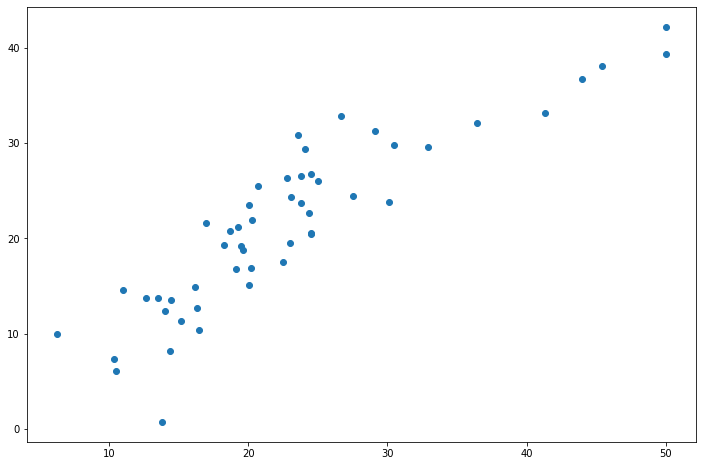

In [ ]:
# Test set plot
plt.figure(figsize=(12, 8))

model = lr().fit(X_train, y_train) # lr for linear regression
predictions = model.predict(X_test)
plt.scatter(y_test, predictions)
plt.show()